In [6]:
import numpy as np
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import os
from sklearn.cluster import KMeans

In [16]:
# Single API endpoint providing all years' budget data
api_endpoint = 'http://127.0.0.1:5000/api/v1.0/linear_regress_rev/actual_vs_predicted/static'

# Fetch the data from the API
response = requests.get(api_endpoint)
response.raise_for_status()  # This will raise an exception for HTTP errors if any occur
data = response.json()

# Convert the JSON data to a DataFrame
# Assuming the JSON data includes a 'Year' field in each record
df = pd.DataFrame(data)

# Print the first few rows to verify data structure
df.head(15)


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Actual,10.994,11.464,11.683,12.287,12.933,13.415,13.531,14.205,15.228,16.468,NaN,NaN,NaN,NaN,NaN
Prediction,10.626,11.195,11.765,12.335,12.905,13.474,14.044,14.614,15.184,15.753,16.323,16.893,17.463,18.032,18.602


In [15]:
# Select relevant numeric features for clustering
# You may need to exclude non-relevant columns such as IDs or descriptive text
features = df.select_dtypes(include=[np.number])  # This selects only numeric columns

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean of each column
features = imputer.fit_transform(features)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled.head(15)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


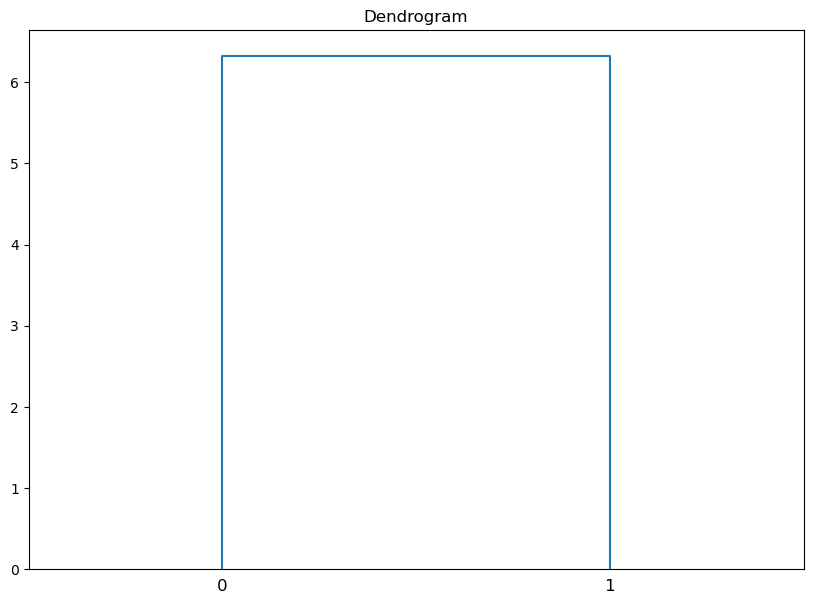

In [11]:
# Perform the clustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(features_scaled)

# Optionally, plot a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(features_scaled, method='ward'))
plt.show()

In [12]:
# Assuming 'features_scaled' is your dataset ready for clustering
import pickle

num_samples = features_scaled.shape[0]
max_clusters = min(num_samples - 1, 10)  # Ensuring we do not attempt too many clusters

for n_clusters in range(2, max_clusters + 1):  # Ensure at least two clusters
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    filename = f"cluster_models/cluster_model_Cluster{n_clusters}"
    with open(filename, "wb") as file:
        pickle.dump(clusterer, file)

    # Calculate and print the silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In [13]:
# Fit the final model
final_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
final_labels = final_cluster.fit_predict(features_scaled)

# Add cluster labels to the original DataFrame
df['Cluster'] = final_labels


# Analyze clusters
for i in range(final_cluster.n_clusters):
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i} Summary:")
    print(cluster_data.describe())

ValueError: Cannot extract more clusters than samples: 5 clusters where given for a tree with 2 leaves.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Column Revenue 2014(millions) not found in DataFrame.
Column Revenue 2015(millions) not found in DataFrame.
Column Revenue 2016(millions) not found in DataFrame.
Column Revenue 2017(millions) not found in DataFrame.
Column Revenue 2018(millions) not found in DataFrame.
Column Revenue 2019(millions) not found in DataFrame.
Column Revenue 2020(millions) not found in DataFrame.
Column Revenue 2021(millions) not found in DataFrame.
Column Revenue 2022(millions) not found in DataFrame.
Column Revenue 2023(millions) not found in DataFrame.


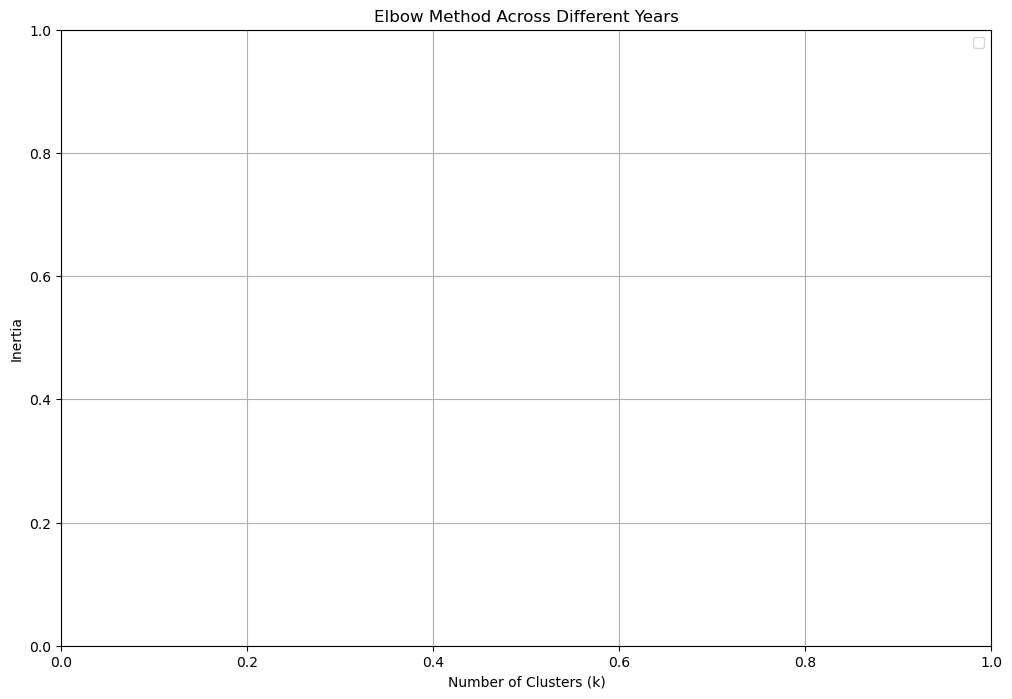

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FF5733', '#C70039', '#900C3F']

scaler = StandardScaler()
plt.figure(figsize=(12, 8))

for year, color in zip(years, colors):
    column_name = f'Revenue {year}(millions)'
    if column_name not in df.columns:
        print(f"Column {column_name} not found in DataFrame.")
        continue

    current_year_data = df[column_name].dropna().values.reshape(-1, 1)
    if current_year_data.size == 0:
        print(f"No data available for year {year}. Skipping...")
        continue

    current_year_data_scaled = scaler.fit_transform(current_year_data)
    num_samples = len(current_year_data_scaled)
    max_k = min(num_samples, 10)
    inertias = []
    k_values = range(1, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(current_year_data_scaled)
        inertias.append(kmeans.inertia_)

    plt.plot(k_values, inertias, marker='o', color=color, label=f'Year {year}')

plt.title('Elbow Method Across Different Years')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
colors = colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FF5733', '#C70039', '#900C3F']  # Define a list of colors for different years

# Ensure data is scaled properly for each year
scaler = StandardScaler()

for idx, year in enumerate(years):
    # Create a figure for each year inside the loop
    plt.figure(figsize=(8, 6))

    # Select the column for the current year and drop NA values
    current_year_data = df[f'Revenue {year}(millions)'].dropna().values.reshape(-1, 1)
    if current_year_data.size == 0:
        print(f"No data available for year {year}. Skipping...")
        continue  # Skip this year if there is no data
    
    current_year_data_scaled = scaler.fit_transform(current_year_data)

    # Dynamically adjust the range of k based on the number of samples
    num_samples = len(current_year_data_scaled)
    max_k = min(num_samples, 10)  # Maximum number of clusters is the lesser of num_samples or 10

    inertias = []
    k_values = range(1, max_k + 1)  # Adjust range to ensure k does not exceed number of samples
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(current_year_data_scaled)
        inertias.append(kmeans.inertia_)

    # Plotting the inertia graph for each year
    plt.plot(k_values, inertias, marker='o', color=colors[idx % len(colors)])  # Use cycling colors list if needed
    plt.title(f'Elbow Method for Year {year}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


In [ ]:
# Example data generation (replace this with your actual data loading code)
from sklearn.datasets import make_blobs
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# Setting the number of clusters to 4 for this example
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data_scaled)

# Getting the cluster labels
cluster_labels = kmeans.labels_

# Getting the coordinates of cluster centers.
cluster_centers = kmeans.cluster_centers_



In [ ]:
# Calculate silhouette score
silhouette_avg = silhouette_score(data_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.6)  # plot centers
plt.title("Visualization of clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()